# Assignment 4.2. Debugging Quantum Repeater Network

One of the potential practical applications of quantum teleportation is in quantum communication networks. One proposed architecture, the quantum repeater, uses local teleportations to propagate a Bell pair across space. Once a Bell pair has been shared, it can be used to perform quantum teleportation from one end of the network to the other.

In [ ]:
import qsharp
import matplotlib.pyplot as plt

We begin implementing this protocol by defining two operations: `BellStateMeasurement` and `TeleportationFixup`. These are nearly identical to the standard parts of teleportation protocol performed by the sender and the receiver. However, this time the operation performing Bell state measurement (previously the sender) will not be preparing a state, because now this operation will just propagate a Bell state down an array.

In [ ]:
%%qsharp
open Microsoft.Quantum.Measurement;

/// # Summary
/// Perform a Bell state measurement and return the results in a tuple.
///
/// # Input
/// ## q1
/// The first qubit in the measurement scheme.
/// ## q2
/// The second qubit in the measurement scheme.
///
/// # Output
/// A tuple of results which indicate the result of the Bell state measurement.
operation BellStateMeasurement(q1 : Qubit, q2 : Qubit) : (Result, Result) {
    CNOT(q1, q2);
    H(q1);
    return (MResetZ(q1), MResetZ(q2));
}

/// # Summary
/// Based on a Bell state measurement result, applies the correct fixup gates
/// to a qubit to complete the teleportation protocol.
/// 
/// # Input
/// ## q
/// Qubit which is acted on.
///
/// ## (m1, m2) 
/// Tuple returned from BellStateMeasurement which tells us the outcome of the Bell state measurement.
operation TeleportationFixup(q : Qubit, (m1 : Result, m2 : Result)): Unit {
    if m1 == One {
        Z(q);
    }
    if m2 != One {
        X(q);
    }
}

With these two operations we can now implement the top-level `QuantumRepeater` operation. We will limit the length of our repeater network to a power of 2. This will greatly simplify the implementation, since the process of spreading the Bell pair over the array doubles the distance between the qubits of the Bell pairs with each iteration.

This operation will perform four steps:

1. Allocate a qubit array of length $2^N$.
2. Prepare each adjacent pair of qubits into a Bell pair.
3. Repeatedly perform the teleportation protocol between adjacent qubit pairs. In this way the distance between the qubits of Bell pairs can be increased until the first and last qubits are the only remaining Bell pair.
4. Use the Bell pair which is now spread over a large distance to perform the teleportation protocol with another qubit.  

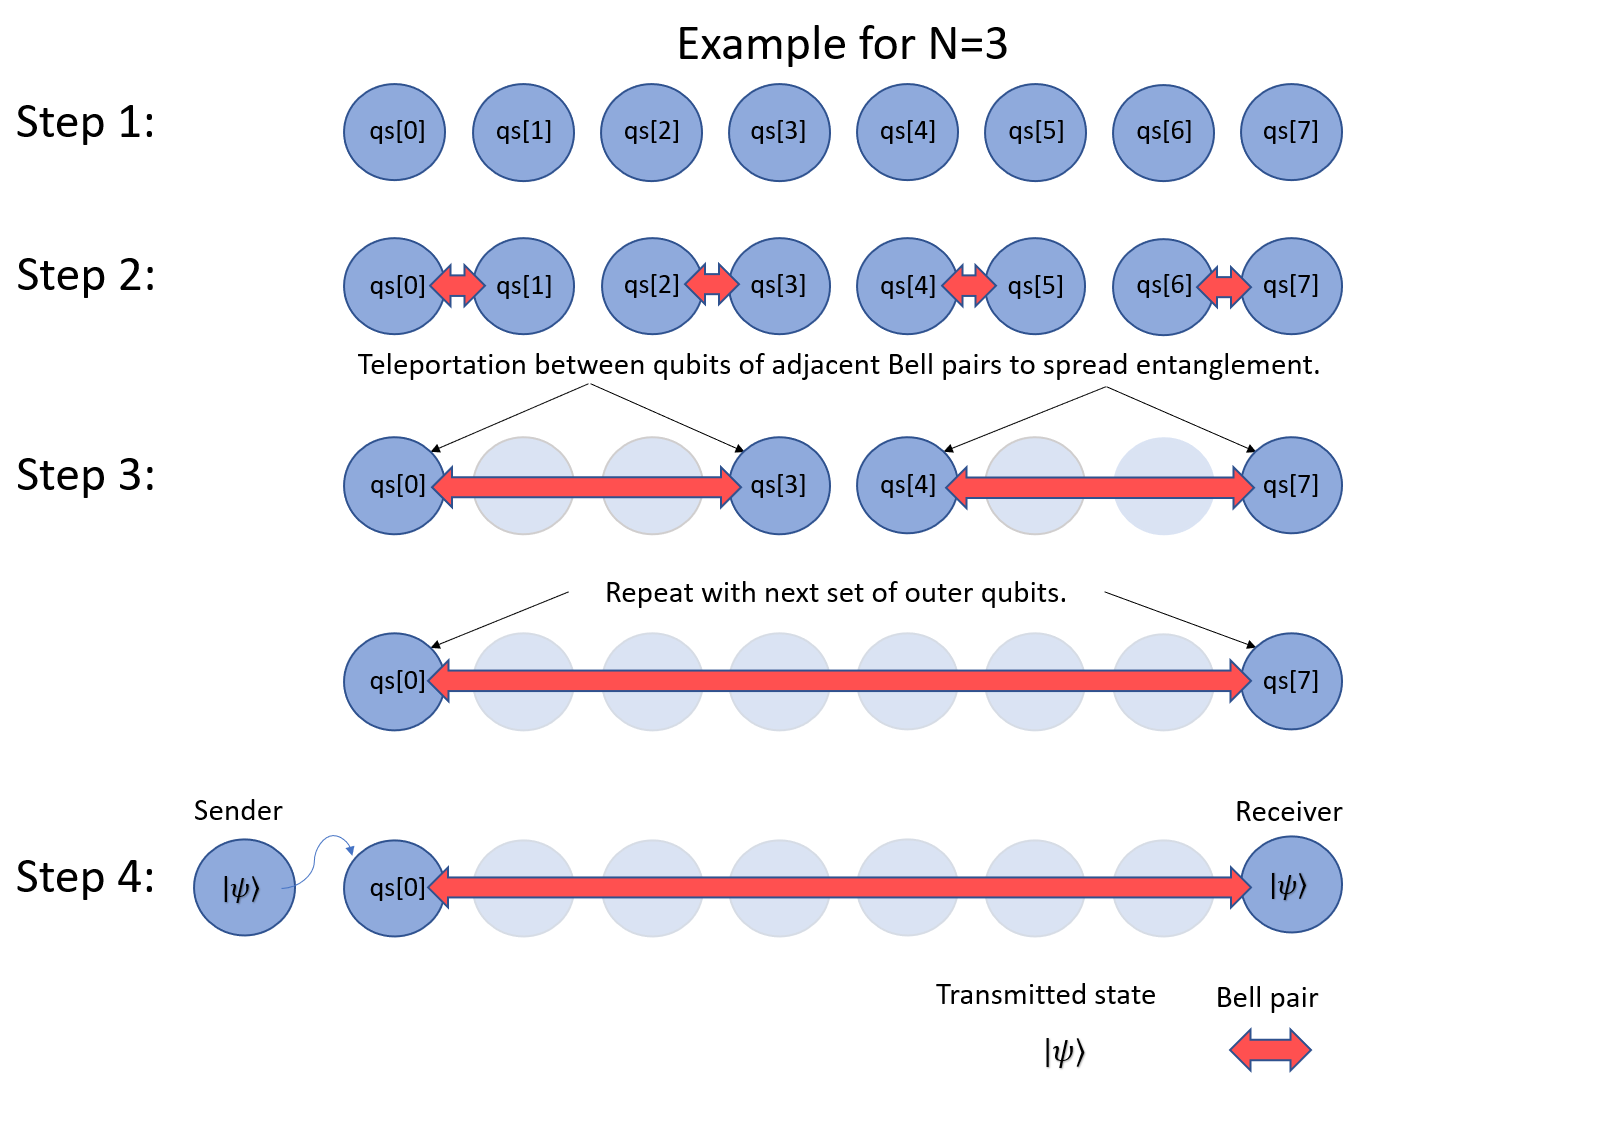

In [ ]:
%%qsharp
// # Summary
/// Takes a qubit and applies an Ry to it.
///
/// # Input
/// ## q
/// The input qubit
operation StatePrepare(q : Qubit) : Unit is Adj {
    Ry(3.1415 / 7.0, q);
}

/// # Summary
/// The top-level quantum repeater operation
/// that implements all steps of a repeater network.
///
/// # Input
/// ## N
/// An integer which gives us the length of the repeater network.
/// The network will have 2^N qubits.
///
/// # Output
/// A result of measuring the final qubit in the repeater network
/// after a state is teleported to it and the adjoint of the PrepareState 
/// operation is applied, so this result should always be Zero.
operation QuantumRepeater(N : Int) : Result {
    use qs = Qubit[2 ^ N];
    // Prepare the Bell pairs
    for i in 0 .. 2 .. Length(qs) - 1 {
        H(qs[i]);
        CNOT(qs[i], qs[i+1]);
    }
    // In this block iteratively teleport states 
    // to entangle more and more distant pairs of qubits
    // until we entangle the two ends of the array.
    for power in 2 .. N {
        let step = 2 ^ power;
        for i in 0 .. step .. Length(qs) - 1 {
            let q1Idx = i + step / 2 - 1;
            let q2Idx = q1Idx + 1;

            let bsm = BellStateMeasurement(qs[q1Idx], qs[q2Idx]);
            TeleportationFixup(qs[i + step / 2 - 1], bsm);
        }
    }
    // Allocate a new qubit and prepare a state to teleport.
    use qToTeleport = Qubit();
    StatePrepare(qToTeleport);

    // Teleport the state.
    let bsm = BellStateMeasurement(qToTeleport, qs[0]);
    TeleportationFixup(qs[Length(qs) - 1], bsm);

    // Apply Adjoint of the state preparation to the teleportation target.
    // It should end up in the |0⟩ state.
    Adjoint StatePrepare(qs[Length(qs) - 1]);
    return MResetZ(qs[Length(qs) - 1]);
}

Run the code below to simulate the repeater network with $2^N$ qubits. You can use values of $N$ from $1$ up to $4$; $N = 5$ or more causes an out-of-memory exception.

In [ ]:
counts = [0, 0]
N = 3
for r in range(100):
    res = qsharp.eval(f"QuantumRepeater({N})")
    counts[0 if res == qsharp.Result.Zero else 1] += 1

plt.bar([0, 1], counts, tick_label = [r"$|0\rangle$", r"$|1\rangle$"])
plt.ylabel("Frequency")
plt.title("Number of 0s and 1s measured")
plt.show()

Since this is a noiseless simulation, we always measure $|0\rangle$.